In [46]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import pandas as pd
from astropy.io import ascii
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import lightkurve as lk
from sklearn.inspection import permutation_importance
import math as m
from sklearn.metrics import r2_score
from rfpimp import permutation_importances
import LS_modular
import bls_modular
import seaborn as sns


# The goal of this notebook is to remove lightcurves that have transits in them - does this catch close binaries that aren't EBs tho?
## Useful Functions

In [2]:
#pandas.set_option('display.max_rows', None) #show all rows
#pandas.set_option('display.max_rows', 10) #go back to only showing 10 rows
#pd.set_option('display.max_columns', None) #show all columns
#pd.set_option('display.max_columns', 10) #go back to only show 10 columns
# pd.reset_option(“max_columns”) #to go back to hiding default number of columns






def uniquefinder(mylist):
    '''
    Function finds unique values within a list, also stats on occurance rates
    
    inputs: an array or list 
            (integers or strings)
    2 outputs: dictionary of occurances, list of unique values 
    '''
    seen = {}
    dupes = []
    uniq_tics = []
    for x in mylist:
        if x not in seen:
            seen[x] = 1
            uniq_tics.append(x)
        else:
            if seen[x] == 1:
                dupes.append(x)
            seen[x] += 1
    uniques = len(uniq_tics)
    print('There are {} unique tics out of the original {}.'.format(uniques,len(mylist)),\
        '\nUse the first output dictionary', \
          'to see number of occurances for duplicates')
    return seen, uniq_tics

# based on training set
def label_meanings(label):
    ''' 
    1== Periodic = "very clear periodicity in light curve"; 
    3== EB = "eclipsing binaries"; 
    '''
    mydictionary = {1:'Astrophysical Signal',3:'Likely Eclipsing Binary',5:'nothing',2:'nothing',4:'nothing'}
    return(mydictionary[label])

def abs_mag(m,D):
    '''
    ~converts apparent mag to absolute mag~
    args:
          m: apparent mag
          D: 1/parallax in parsecs
    RETURNS: absolute mag
    '''
    return m - 5*np.log10(D) + 5

def mas_to_parsec(mas):
    '''
    ~converts milliarcseconds(mas) to parsecs, useful b/c Gaia parallax in mas~
    args:
         mas: parallax measure in mas
    RETURNS: parallax in parsecs
    '''
    return mas * 1000

def get_D(parallax):
    '''
    ~converts parallax to distance~
    args:
        parrallax: parallax measure in mas
    RETURNS: distance
    '''
    plx = mas_to_parsec(parallax)
    return 1/plx

def slope(x1,x2,y1,y2):
    ''' 
    inputs: coordinates for 2 plotted datapoints
    returns: slope
    '''
    m = (y2 -y1) / (x2-x1)
    return (y2 -y1) / (x2-x1)

def get_b(m,x,y):
    '''
    gives y-intercept(b) for a straight line
    inputs: slope(m); point on line(x,y)
    returns: b
    '''
    b = -(m*x) + y
    return b

## Load Data

In [47]:
#RF1 results
unseen_RF1 = pd.read_csv('data/RF1_results.csv') #only periodics, no giants; doesnt include all features tho
#unseen data but has giants in it so make sure match up to unseen_RF1
allstats = pd.read_csv('data/allstats_secs14_15_nogiants.csv') #note this doesnt have BLS STATs
#for comparisons later
mqdata = pd.read_csv('data/mcquillan_sample.csv')



#training examples
labels_df = pd.read_csv('data/RF1_TrainingSet_nogiants.csv')# cant use b/c doesnt have ebs
#training/testing examples from CVZ 
labels_data = ascii.read('data/master_bls_bigstats_stitchedlcs.fits')
labels = pd.read_csv('data/RF2_Classification_TICS_3.csv', header=4)
#training/testing examples from Sectors 14&15
morelabels = pd.read_csv('data/RF1-TrainingSet.csv')




## Format Data & Select Features to use
### _Format Unseen Data_

##### ------start of a side test for why merge drops some training examples-----

In [4]:
##find an example tic----using index 11802
# unseen_RF1

In [5]:
##ensure example tic is in ticcat df
# sub_ticcat = allstats_withBLS[allstats_withBLS['TIC']==99936804]
# sub_ticcat

In [6]:
# # test if merge matches for this example tic
# atest = pd.merge(unseen_RF1, sub_ticcat, on='TIC') #on = ['TIC','rvar'])

# pd.set_option('display.max_columns', None)
# atest[atest['TIC']==99936804] #it didnt match them despite values matching--only works if match based on TIC alone

In [7]:
# # test if truly equilvant or like a data type issue
# sub_id = sub_ticcat['TIC'].to_numpy()[1]
# sub_rvar = sub_ticcat['rvar'].to_numpy()[1]
# all_id = unseen_RF1['TIC'].iloc[11802]
# all_rvar = unseen_RF1['rvar'].iloc[11802]
# sub_ls = sub_ticcat['ls-1'].to_numpy()[1]
# all_ls = unseen_RF1['ls1'].iloc[11802]

# print('tics: {} =?= {}'.format(sub_id,all_id))
# print('rvars: {} =?= {}'.format(sub_rvar,all_rvar))
# print('lss: {} =?= {}'.format(sub_ls,all_ls))

# if sub_rvar == all_rvar:
#     print('rvar match')
# else:
#     pass
# if sub_id == all_id:
#     print('id match')
# else:
#     pass
# if sub_ls == all_ls:
#     print('ls match')
# else:
#     pass

In [8]:
print('test results ----- floats go to diff decimal places so wont match \ntry--- to add a column to each df based on a multiplied rounded value of rvar or ls1')

test results ----- floats go to diff decimal places so wont match 
try--- to add a column to each df based on a multiplied rounded value of rvar or ls1


In [9]:
#see if try to match full dfs

# print(len(allstats),'-no giants',len(allstats_withBLS),'-still has giants')
# MYTEST = pd.merge(allstats,allstats_withBLS, on = ['TIC','rvar'])
# len(MYTEST)

##### -----end of side test, no solutions yet but problem is due to float cut off-----
#### could try adding a column to each df with rvar value rounded and match based on that col as 2ndary
### continue to proceed with slightly reduced training sample b/c can only improve once float matching issue is fixed and can add in more  examples

In [10]:
## combine unseen results from RF1 (nogiants) with tic catalog

allstats_withBLS = pd.read_csv('/Volumes/Seagate-stars/SECTORS/allstats_14_15.csv')
# pd.set_option('display.max_columns', 10)


#merge RF1 results with full ticcat to get new features
unseen_nogiants = pd.merge(unseen_RF1[['TIC','ls1']], allstats_withBLS, left_on=['TIC','ls1'],right_on=['TIC','ls-1']) #on = ['TIC','rvar'])
unseen_nogiants = unseen_nogiants.rename(columns={"transit_time":'transittime'}) #rename to avoid latex issue 


print('before:',len(unseen_RF1),'after:',len(unseen_nogiants),'should match')
print('doesnt match b/c of float issue above; for now proceed and will get remaining ~500 stars predictions later')
print('\nThe "unseen_nogiants" df is ready to have features selected ')
unseen_nogiants

before: 11807 after: 11341 should match
doesnt match b/c of float issue above; for now proceed and will get remaining ~500 stars predictions later

The "unseen_nogiants" df is ready to have features selected 


,TIC,ls1,period_bls,power_bls,depth_bls,dur_bls,tt_bls,Sector,rvar,ls-1,...,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,objID
0,100008376,5.966919,0.300162,3,0.000190,0.29,0.166,14,41.565918,5.966919,...,NaN,0.778199,0.608174,172.594452,64.296247,0.024917,0.020003,1,0,143482901
1,100010286,6.490677,0.302985,55,0.000065,0.29,0.160,14,343.870508,6.490677,...,NaN,0.650925,0.569246,172.805184,63.157644,0.018637,0.018574,1,0,143483869
2,100011130,6.327233,0.308377,153,0.000050,0.29,0.171,14,110.547852,6.327233,...,NaN,0.728036,0.710188,172.980337,62.517275,0.018674,0.020107,1,0,143484401
3,100011208,6.614793,0.302603,48,0.000161,0.29,0.151,14,44.024072,6.614793,...,NaN,1.047266,0.947109,172.986686,62.050373,0.029882,0.030739,1,0,143484422
4,100011351,3.376855,0.300865,16,0.000033,0.29,0.160,14,2164.406250,3.376855,...,NaN,9.356969,9.540352,173.086115,61.082209,0.292335,0.282867,1,0,143565767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11336,99936804,1.991261,0.300486,9,0.000150,0.29,0.165,15,51.038281,1.991261,...,NaN,0.737344,0.677820,169.924913,63.460754,0.020488,0.020215,1,0,142994292
11337,99956360,9.945577,0.300216,4,0.000038,0.29,0.154,15,227.912500,9.945577,...,NaN,0.867590,0.829796,171.065568,65.045116,0.025660,0.027336,1,0,143243048
11338,99988199,11.897165,0.301516,28,0.000199,0.29,0.161,15,46.279150,11.897165,...,NaN,0.723434,0.648032,171.879720,64.296178,0.019699,0.019341,1,0,143322493
11339,99989665,3.320681,0.301353,25,0.000970,0.29,0.146,15,24.063239,3.320681,...,cooldwarfs_v8,1.753273,1.593195,172.359806,62.125333,0.052553,0.052011,1,0,143403992


### _Format Training Examples_ 

In [11]:
#must redo subsampling & remove giants from features

#make formats match
labels_data_df = labels_data.to_pandas()
#rename column for matching ease
labels_data_df = labels_data_df.rename(columns={"ID": 'TIC'})
#match CVZ labels into one df
features = pd.merge(labels_data_df, labels, on='TIC')#lose 7 here but its ok, proceed
#drop high teff CVZ examples
features = features[features['Teff']<=6500] #lost 43 here but its ok, proceed
#only keep CVZ periodic(1) or EBs(3) labels
features = features[(features['CLASS']==1) | (features['CLASS']==3)]

features

/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'HIP' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'KIC' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'numcont' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'gaiaqflag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarnin

,TIC,TOTsecs,rvar,ls1,ls2,ls3,lsamp1,lsamp2,lsamp3,acf1,...,power,period,depth,transit_time,duration,CLASS,LS_correct,ACF_correct,ACF2_correct,# comments
1,25078924,13,0.092320,0.906772,0.902284,0.896550,0.294121,0.062172,0.057633,0.904167,...,2128,1.808656,0.003801,0.624,0.16,3,NaN,NaN,NaN,NaN
3,25155310,13,0.005393,1.644398,1.096231,0.822214,0.037454,0.036482,0.034500,3.288892,...,6023,3.288786,0.001560,2.208,0.16,3,NaN,NaN,NaN,NaN
6,30313682,12,0.036663,2.863217,1.431896,0.954571,0.134459,0.102553,0.087986,2.863891,...,12441,5.727675,0.095033,4.592,0.16,3,NaN,NaN,NaN,NaN
8,31273263,11,0.018080,12.559911,12.007478,6.253588,0.329218,0.129200,0.094600,12.776399,...,27070,11.286806,0.000296,1.360,0.16,3,1.0,1.0,1.0,# could be a 1 b/c its a huge planet with ~ 22...
10,32150630,12,0.057739,1.485555,0.745751,1.494213,0.452719,0.104419,0.077054,1.491668,...,1295,1.492110,0.006370,0.448,0.16,1,1.0,1.0,0.0,# acf2 is a double harmonic; also these rps ar...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,358510596,10,0.002464,0.664410,0.556352,0.589544,0.018086,0.017529,0.015374,0.069445,...,48910,19.586172,0.000076,13.952,0.16,1,1.0,0.0,1.0,# ls1 & acf2 only off by ~0.1
331,364302118,12,0.035577,0.672685,1.346318,1.380921,0.440631,0.052412,0.032581,1.345834,...,909,1.345427,0.007843,1.104,0.16,3,NaN,NaN,NaN,NaN
334,382069441,12,0.035260,5.477068,5.594156,5.365352,0.634746,0.129890,0.104538,5.488893,...,40711,16.470489,0.002633,1.792,0.16,3,NaN,NaN,NaN,#investigate this huge planet more
335,382517745,13,0.008261,10.419558,5.311744,5.424710,0.090711,0.085972,0.061831,10.441675,...,24844,10.440909,0.000277,1.232,0.16,3,NaN,NaN,NaN,NaN


In [12]:
#############################################################################
#############################################################################
####### test w & w/o these EXTRA TRAINING EXAMPLES from sectors 14 & 15
#############################################################################
#############################################################################

#find unique EB tics
mytest2, mytest3 = uniquefinder(morelabels['Transiting'])
# len(mytest3)
#match unique EB tics to a sector
EBsecs=[]
for tic in mytest3:
    df = allstats[allstats['TIC']==tic]
    sec = df['Sector'].iloc[0]
    EBsecs.append(sec)
    
## below pulls data for EBs & Periodics examples     
#pull columns & remove nans
sec1415_tics_p = morelabels['Periodic'].to_numpy()[~np.isnan(morelabels['Periodic'].to_numpy())] 
sec1415_secs_p = morelabels['P_sector'].to_numpy()[~np.isnan(morelabels['P_sector'].to_numpy())]
sec1415_tics_t = mytest3
sec1415_secs_t = EBsecs

#generate labels
periodics_label_list = np.repeat(1,len(sec1415_tics_p))
transits_label_list = np.repeat(3,len(sec1415_tics_t))
#combine columns
sec1415_labels = np.append(periodics_label_list, transits_label_list)
sec1415_tics = np.append(sec1415_tics_p, sec1415_tics_t)
sec1415_secs = np.append(sec1415_secs_p, sec1415_secs_t)

#put into new df
sec1415_info = {'TIC': sec1415_tics, 'Sector': sec1415_secs, 'CLASS': sec1415_labels}
extralabels_1 = pd.DataFrame(sec1415_info)
#merge these examples with their data 
extralabels_2 = pd.merge(allstats, extralabels_1, on=['TIC','Sector'])
#rename some columns to match features
extralabels_3 = extralabels_2.rename(columns={"ls-1": 'ls1','ls-2':'ls2','ls-3':'ls3','lsamp-1':'lsamp1',
                                         'lsamp-2':'lsamp2','lsamp-3':'lsamp3'})

###note these CVZ examples have NO BLS stats###

print('Before merge length:',len(features))
#merge with CVZ features 
features = pd.concat([features, extralabels_3])
print('adding {} cvz examples; {}EBs & {}periodics'.format(len(extralabels_3),len(EBsecs),len(sec1415_tics_p)))
#do a teff cut to match desired range
features = features[features['Teff']<=6500]
#do another cut if dont have necessary data to be sure on MS
step1 = features[pd.notna(features['plx']).to_numpy()]
step2 = step1[pd.notna(step1['GAIAmag'].to_numpy())]
features = step2[pd.notna(step2['Teff'].to_numpy())]

features

There are 37 unique tics out of the original 46. 
Use the first output dictionary to see number of occurances for duplicates
Before merge length: 157
adding 82 cvz examples; 37EBs & 45periodics


,TIC,TOTsecs,rvar,ls1,ls2,ls3,lsamp1,lsamp2,lsamp3,acf1,...,depth,transit_time,duration,CLASS,LS_correct,ACF_correct,ACF2_correct,# comments,Sector,GAIA_AbsMag
1,25078924,13.0,0.092320,0.906772,0.902284,0.896550,0.294121,0.062172,0.057633,0.904167,...,0.003801,0.624000,0.16,3,NaN,NaN,NaN,NaN,NaN,NaN
3,25155310,13.0,0.005393,1.644398,1.096231,0.822214,0.037454,0.036482,0.034500,3.288892,...,0.001560,2.208000,0.16,3,NaN,NaN,NaN,NaN,NaN,NaN
6,30313682,12.0,0.036663,2.863217,1.431896,0.954571,0.134459,0.102553,0.087986,2.863891,...,0.095033,4.592000,0.16,3,NaN,NaN,NaN,NaN,NaN,NaN
8,31273263,11.0,0.018080,12.559911,12.007478,6.253588,0.329218,0.129200,0.094600,12.776399,...,0.000296,1.360000,0.16,3,1.0,1.0,1.0,# could be a 1 b/c its a huge planet with ~ 22...,NaN,NaN
11,38586438,11.0,0.021472,1.110549,0.555587,1.115110,0.242232,0.179837,0.042648,1.111112,...,0.027721,0.089038,0.16,3,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,53569838,NaN,5909.745313,7.308811,18.858413,5.054958,0.289424,0.171771,0.123088,NaN,...,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,15.0,35.682523
78,53569840,NaN,2167.484375,7.367451,4.965988,3.552133,0.250747,0.241147,0.123060,NaN,...,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,15.0,35.318587
79,55753802,NaN,8163.602930,0.555519,1.442159,0.511329,0.000167,0.000158,0.000152,NaN,...,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,15.0,33.082886
80,55778901,NaN,3005.557910,11.428718,1.290782,2.529263,0.000129,0.000103,0.000102,NaN,...,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,15.0,34.146984


In [13]:
## maybe could delete
# list(extralabels_3.columns)
# list(allstats.columns)

### _Keep only Main Sequence stars in Training Set (unseen already had giants removed-overplotted confirms)_

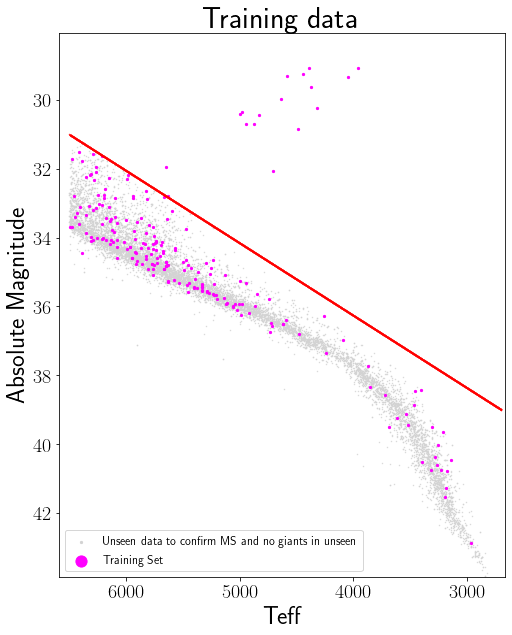

In [14]:
#remove giants from features

## add Abs_Mag column & find division line ---to remove giants from unseen & training data
## for unseen
u_abs_GAIAmag = []
u_teffs =[]
for plx,mag,temp in unseen_nogiants[['plx','GAIAmag','Teff']].to_numpy():
    D = get_D(plx)
    newmag=abs_mag(mag,D)
    u_abs_GAIAmag.append(newmag)
    u_teffs.append(temp)
#add to df
unseen_nogiants['GAIA_AbsMag'] = u_abs_GAIAmag

## for training
t_abs_GAIAmag = []
t_teffs =[]
for plx,mag,temp in features[['plx','GAIAmag','Teff']].to_numpy():
    D = get_D(plx)
    newmag=abs_mag(mag,D)
    t_abs_GAIAmag.append(newmag)
    t_teffs.append(temp)
#add to df
features['GAIA_AbsMag'] = t_abs_GAIAmag

################note that red line is the SAME as on unseen data & RF-1 to ensure training & predicitions share same parameter space
## for training
#determine division line params
t_pt1 = [6500,31]
t_pt2 = [2700,39]
t_m = slope(t_pt1[0],t_pt2[0],t_pt1[1],t_pt2[1])
t_b = get_b(t_m,t_pt1[0],t_pt1[1])
#create arrays for line
t_xarr = np.arange(t_pt2[0],t_pt1[0],1)
t_yarr = [t_m*x + t_b for x in t_xarr]

##plot 
plt.figure(figsize=(8,10))
plt.scatter(u_teffs,u_abs_GAIAmag,s=.2,label='Unseen data to confirm MS and no giants in unseen',color='lightgrey')
plt.scatter(t_teffs,t_abs_GAIAmag,s=5,label='Training Set',color='magenta')
plt.scatter(t_xarr,t_yarr,color='r',s=.2)
plt.legend(fontsize='large',markerscale=5)
plt.ylabel('Absolute Magnitude');plt.xlabel('Teff');
plt.xlim(max(t_teffs)+100,min(t_teffs)-300)
plt.ylim(max(t_abs_GAIAmag)+1,min(t_abs_GAIAmag)-1);
plt.title('Training data',fontsize=30);




For training examples use: 
------------------ 
"features_nogiants" 
 
For unseen data use: 
------------------ 
"unseen_nogiants"


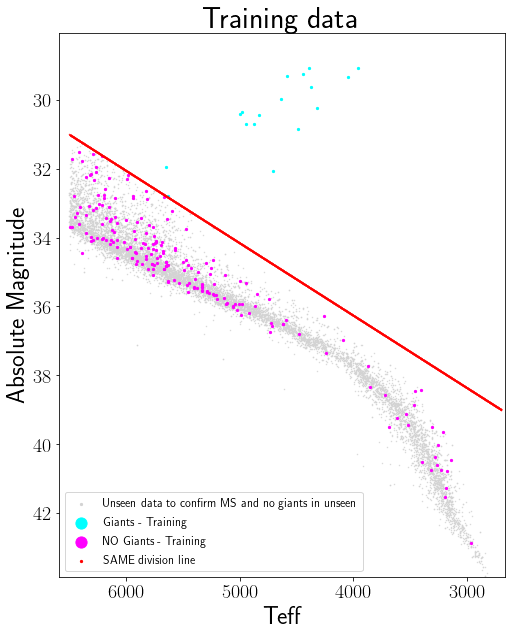

In [15]:
## remove giants & replot to confirm

#do cut for features
compare_values = [t_m*x + t_b for x in features['Teff'].to_numpy()] #ABSmagnitude value on the red line at star's teff
features_nogiants = features[[features['GAIA_AbsMag'].to_numpy()[i] > compare_values[i] for i in range(len(compare_values))]]
features_giantsonly = features[[features['GAIA_AbsMag'].to_numpy()[i] <= compare_values[i] for i in range(len(compare_values))]]

#plot to verify
plt.figure(figsize=(8,10))
plt.scatter(u_teffs,u_abs_GAIAmag,s=.2,label='Unseen data to confirm MS and no giants in unseen',color='lightgrey')
plt.scatter(features_giantsonly['Teff'].to_numpy(),features_giantsonly['GAIA_AbsMag'].to_numpy(),s=5,label='Giants - Training',color='cyan')
plt.scatter(features_nogiants['Teff'].to_numpy(),features_nogiants['GAIA_AbsMag'].to_numpy(),s=5,label='NO Giants - Training',color='magenta')
plt.scatter(t_xarr,t_yarr,color='r',s=.2,label='SAME division line')
plt.legend(fontsize='large',markerscale=5)
plt.ylabel('Absolute Magnitude');plt.xlabel('Teff');
plt.xlim(max(t_teffs)+100,min(t_teffs)-300)
plt.ylim(max(t_abs_GAIAmag)+1,min(t_abs_GAIAmag)-1);
plt.title('Training data',fontsize=30);

print('For training examples use: \n------------------ \n"features_nogiants" \n \nFor unseen data use: \n------------------ \n"unseen_nogiants"')

### _Decide Features to Use_


In [16]:
#check totals to see where the nans are


#rename a column to avoid latex probs
features = features.rename(columns={"transit_time":'transittime'}) #rename to avoid latex issue 


nan_features_lists = ['TOTsecs',
                    'period','depth','transittime','duration',
                      'LS_correct','ACF_correct','ACF2_correct','Sector', '#comments'
                     'acf1','acf2',]
print(list(features.columns))
pd.set_option('display.max_columns', None) #show all columns
#pd.set_option('display.max_columns', 10) #go back to only show 10 columns

features.describe(include='all') #arg to get all columns to show-except it isnt working FUN!

['TIC', 'TOTsecs', 'rvar', 'ls1', 'ls2', 'ls3', 'lsamp1', 'lsamp2', 'lsamp3', 'acf1', 'acf2', 'acf3', 'acfamp1', 'acfamp2', 'acfamp3', 'version', 'HIP', 'TYC', 'UCAC', 'TWOMASS', 'SDSS', 'ALLWISE', 'GAIA', 'APASS', 'KIC', 'objType', 'typeSrc', 'ra', 'dec', 'POSflag', 'pmRA', 'e_pmRA', 'pmDEC', 'e_pmDEC', 'PMflag', 'plx', 'e_plx', 'PARflag', 'gallong', 'gallat', 'eclong', 'eclat', 'Bmag', 'e_Bmag', 'Vmag', 'e_Vmag', 'umag', 'e_umag', 'gmag', 'e_gmag', 'rmag', 'e_rmag', 'imag', 'e_imag', 'zmag', 'e_zmag', 'Jmag', 'e_Jmag', 'Hmag', 'e_Hmag', 'Kmag', 'e_Kmag', 'TWOMflag', 'prox', 'w1mag', 'e_w1mag', 'w2mag', 'e_w2mag', 'w3mag', 'e_w3mag', 'w4mag', 'e_w4mag', 'GAIAmag', 'e_GAIAmag', 'Tmag', 'e_Tmag', 'TESSflag', 'SPFlag', 'Teff', 'e_Teff', 'logg', 'e_logg', 'MH', 'e_MH', 'rad', 'e_rad', 'mass', 'e_mass', 'rho', 'e_rho', 'lumclass', 'lum', 'e_lum', 'd', 'e_d', 'ebv', 'e_ebv', 'numcont', 'contratio', 'disposition', 'duplicate_id', 'priority', 'eneg_EBV', 'epos_EBV', 'EBVflag', 'eneg_Mass', 'e

,TIC,TOTsecs,rvar,ls1,ls2,ls3,lsamp1,lsamp2,lsamp3,acf1,acf2,acf3,acfamp1,acfamp2,acfamp3,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,KIC,objType,typeSrc,ra,dec,POSflag,pmRA,e_pmRA,pmDEC,e_pmDEC,PMflag,plx,e_plx,PARflag,gallong,gallat,eclong,eclat,Bmag,e_Bmag,Vmag,e_Vmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,TWOMflag,prox,w1mag,e_w1mag,w2mag,e_w2mag,w3mag,e_w3mag,w4mag,e_w4mag,GAIAmag,e_GAIAmag,Tmag,e_Tmag,TESSflag,SPFlag,Teff,e_Teff,logg,e_logg,MH,e_MH,rad,e_rad,mass,e_mass,rho,e_rho,lumclass,lum,e_lum,d,e_d,ebv,e_ebv,numcont,contratio,disposition,duplicate_id,priority,eneg_EBV,epos_EBV,EBVflag,eneg_Mass,epos_Mass,eneg_Rad,epos_Rad,eneg_rho,epos_rho,eneg_logg,epos_logg,eneg_lum,epos_lum,eneg_dist,epos_dist,distflag,eneg_Teff,epos_Teff,TeffFlag,gaiabp,e_gaiabp,gaiarp,e_gaiarp,gaiaqflag,starchareFlag,VmagFlag,BmagFlag,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,objID,power,period,depth,transittime,duration,CLASS,LS_correct,ACF_correct,ACF2_correct,# comments,Sector,GAIA_AbsMag
count,2.220000e+02,140.00000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,222.0,60.000000,212,221,222,149,213,2.220000e+02,189,1.500000e+01,222,222,222.000000,222.000000,222,222.000000,222.000000,222.000000,222.000000,222,222.000000,222.000000,222,222.000000,222.000000,222.000000,222.000000,219.000000,218.000000,222.000000,222.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222,0.0,210.000000,209.000000,211.000000,211.000000,211.000000,210.000000,211.000000,172.000000,222.000000,222.000000,222.000000,222.000000,222,222,222.000000,211.000000,193.000000,191.000000,76.000000,76.000000,218.000000,191.000000,193.000000,191.000000,193.000000,191.000000,222,193.000000,191.000000,222.000000,211.000000,210.000000,204.000000,202.000000,202.000000,140,140,200.000000,204.000000,204.000000,172,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,201.000000,201.000000,222,169.000000,169.000000,222,222.000000,222.000000,222.000000,222.000000,222.000000,140,222,220,147,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,2.220000e+02,140.000000,140.000000,140.000000,140.000000,1.400000e+02,222.000000,104.000000,104.000000,104.000000,74,82.000000,222.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,172,214,215,10,207,2.150000e+02,181,NaN,1,1,NaN,NaN,1,NaN,NaN,NaN,NaN,3,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,1,9,7,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N/A,709-059575,15292366+8027010,N,J152922.71+802701.9,1.668691e+18,N/A,NaN,STAR,tmgaia2,NaN,NaN,tmgaia2,NaN,NaN,NaN,NaN,gaia2,NaN,NaN,gaia2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAA-222-111-000-0-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rered,spect,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DWARF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N/A,N,NaN,NaN,NaN,schlegel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bj2018,NaN,NaN,spect,NaN,NaN,NaN,NaN,NaN,N,tycho2v3,tycho2b3,N/A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,# acf2 is a double harmonic,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34,2,2,140,2,2.000000e+00,8,NaN,222,222,NaN,NaN,222,NaN,NaN,NaN,NaN

#### NOTE: b/c want to use BLS stats in this it drops the 82 CVZ examples that did not have BLS stats
#### TLDR: CVZ examples are useless

In [17]:
#finalize list of features used

features_list = ['TIC','rvar','Teff',
                 'ls1', 'ls2', 'ls3', 'lsamp1', 'lsamp2', 'lsamp3',
                 'power', 'period', 'depth', 'transittime', 'duration',
                 'Vmag','Tmag','CLASS']
#would like to use these BUT would cause a reduction in my training sample due to nans
extra_features_list = ['logg','Bmag'] #have nans

########################################################
## merge here if want to add features to features_lists 
# added_feature = ['mytest']
# features_list = features_list + added_feature
########################################################

#select features
short_features = features[features_list]
#remove any nans in the final features
short_features = short_features.dropna()


#check final distribution for possible problems
short_features.describe(include='all')

,TIC,rvar,Teff,ls1,ls2,ls3,lsamp1,lsamp2,lsamp3,power,period,depth,transittime,duration,Vmag,Tmag,CLASS
count,1.400000e+02,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,1.400000e+02,140.000000,140.000000,140.000000
mean,1.768927e+08,0.034879,5313.286500,6.150649,5.601327,6.275399,0.212820,0.084019,0.054072,26611.835714,11.112700,0.003342,5.385994,1.600000e-01,11.104919,10.181700,1.414286
std,6.900012e+07,0.064574,912.176976,7.393368,5.445059,7.373544,0.211991,0.078338,0.049643,17673.587366,6.716098,0.017421,5.216204,1.114209e-16,2.030605,1.587051,0.813428
min,2.507892e+07,0.001149,2967.000000,0.501684,0.500644,0.500600,0.000044,0.000027,0.000024,2.000000,1.000760,0.000011,0.023936,1.600000e-01,6.360000,5.519700,1.000000
25%,1.419357e+08,0.006617,4942.312500,1.685905,1.412170,1.449781,0.036664,0.018601,0.015181,3215.000000,2.221724,0.000078,1.100000,1.600000e-01,9.810250,9.125675,1.000000
50%,1.502196e+08,0.013611,5629.885000,4.635157,4.488828,4.458951,0.142039,0.068190,0.038063,32967.500000,13.527901,0.000192,3.400000,1.600000e-01,10.866500,10.262750,1.000000
75%,1.769398e+08,0.035534,5989.275000,7.151871,6.564724,6.871282,0.322236,0.120016,0.081811,40721.500000,16.474479,0.000604,8.944000,1.600000e-01,11.787750,10.938175,1.000000
max,4.047680e+08,0.533736,6494.000000,49.558430,33.578120,42.724756,0.942124,0.393254,0.249504,49979.000000,19.992400,0.180532,19.760000,1.600000e-01,17.170000,14.718700,3.000000


In [18]:
len(list(short_features.columns))

17

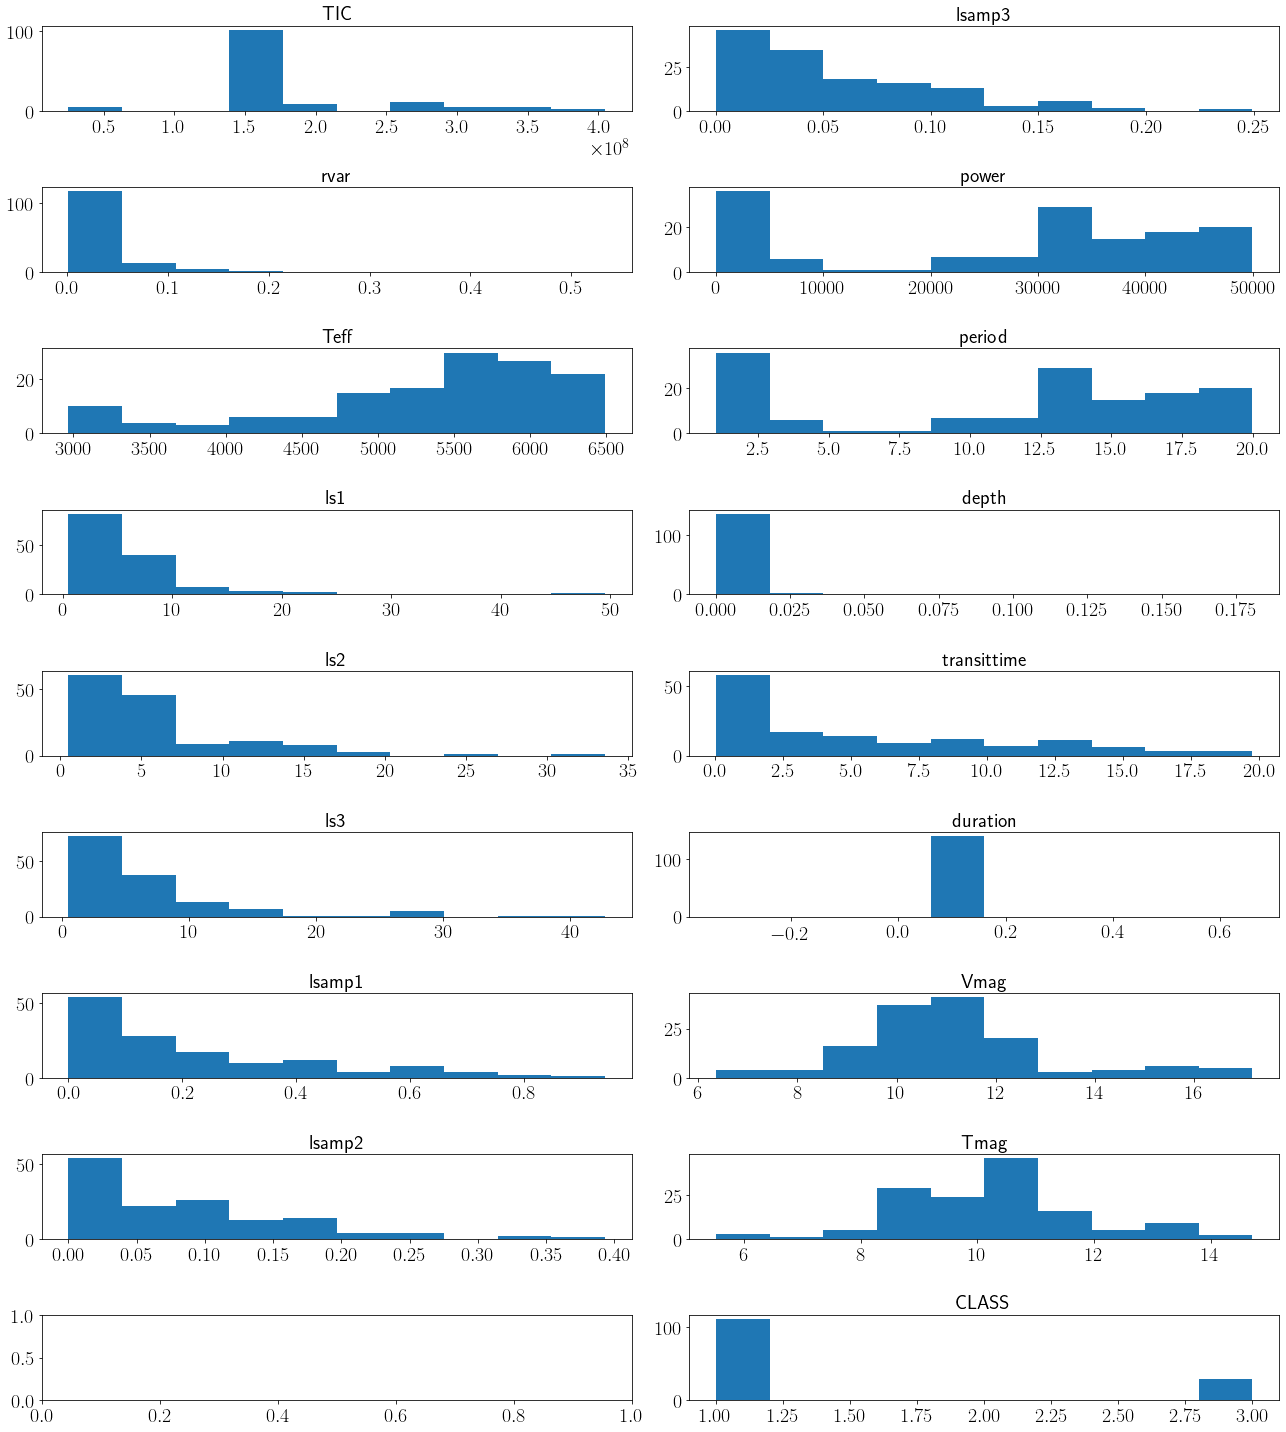

In [20]:
# explore distribution of training examples
f, ax = plt.subplots(9,2,figsize=(18,20))
for count,col in enumerate(list(short_features.columns)):
    
    if count <8: #count % 2 ==False: #even
        ax[count,0].hist(short_features[col])
        ax[count,0].set_title(col,fontsize=20)
    else: #odd
#         print(count-8)
        ax[count-8,1].hist(short_features[col])
        ax[count-8,1].set_title(col,fontsize=20)
plt.tight_layout()

In [21]:
## inject random number as feature
np.random.seed(seed = 11)
short_features['random'] = np.random.random(size = len(short_features))
short_features

,TIC,rvar,Teff,ls1,ls2,ls3,lsamp1,lsamp2,lsamp3,power,period,depth,transittime,duration,Vmag,Tmag,CLASS,random
1,25078924,0.092320,5737.00,0.906772,0.902284,0.896550,0.294121,0.062172,0.057633,2128.0,1.808656,0.003801,0.624000,0.16,11.327,10.7050,3,0.180270
3,25155310,0.005393,5675.54,1.644398,1.096231,0.822214,0.037454,0.036482,0.034500,6023.0,3.288786,0.001560,2.208000,0.16,10.994,10.6103,3,0.019475
6,30313682,0.036663,6100.00,2.863217,1.431896,0.954571,0.134459,0.102553,0.087986,12441.0,5.727675,0.095033,4.592000,0.16,10.604,10.0624,3,0.463219
8,31273263,0.018080,5631.77,12.559911,12.007478,6.253588,0.329218,0.129200,0.094600,27070.0,11.286806,0.000296,1.360000,0.16,11.341,10.7858,3,0.724934
11,38586438,0.021472,3471.00,1.110549,0.555587,1.115110,0.242232,0.179837,0.042648,292.0,1.110962,0.027721,0.089038,0.16,14.041,11.6704,3,0.420204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,358510596,0.002464,4636.00,0.664410,0.556352,0.589544,0.018086,0.017529,0.015374,48910.0,19.586172,0.000076,13.952000,0.16,9.344,8.2903,1,0.313679
331,364302118,0.035577,5813.00,0.672685,1.346318,1.380921,0.440631,0.052412,0.032581,909.0,1.345427,0.007843,1.104000,0.16,10.928,10.3606,3,0.930766
334,382069441,0.035260,5057.00,5.477068,5.594156,5.365352,0.634746,0.129890,0.104538,40711.0,16.470489,0.002633,1.792000,0.16,12.158,11.3792,3,0.238346
335,382517745,0.008261,5674.00,10.419558,5.311744,5.424710,0.090711,0.085972,0.061831,24844.0,10.440909,0.000277,1.232000,0.16,11.197,10.5992,3,0.420391


In [22]:
#print final info

#split training labels from data
final_labels = short_features['CLASS'].to_numpy()
final_features = short_features.drop(columns=['CLASS'])
# print('verify these match {} = {}\n'.format(len(final_labels),len(final_features)))

# print final number of training examples and which features used
print('{} Features Used. \nThey are {}'.format(len(final_features.columns),list(final_features.columns)))
print('{} Training Examples Used.'.format(len(final_features)))
print('\n------------------------------- \nUse "final_labels" & "final_features"')

17 Features Used. 
They are ['TIC', 'rvar', 'Teff', 'ls1', 'ls2', 'ls3', 'lsamp1', 'lsamp2', 'lsamp3', 'power', 'period', 'depth', 'transittime', 'duration', 'Vmag', 'Tmag', 'random']
140 Training Examples Used.

------------------------------- 
Use "final_labels" & "final_features"


## Build, train, test RF classifier-----------------------------

In [23]:
#set variable for feature data
X = final_features.reset_index(drop=True)
#set variable for correct labels
y = final_labels
#split data into test and training set
X_train, test_X, y_train, test_y = train_test_split(X, y, random_state = 11)

In [24]:
######play with parms here to get better model


#define random forest model
rf_model = RandomForestClassifier(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 11,
                           max_depth = 4) #criterion='entropy'
# fit model to data
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, n_jobs=-1, oob_score=True, random_state=11)

In [25]:
# print accuracy scores
print('Test Set Accuracy:',rf_model.score(test_X,test_y))  
print('Training Set Accuracy:', rf_model.score(X_train,y_train))
print('Out of the Box Accuracy:',rf_model.oob_score_)

Test Set Accuracy: 0.8571428571428571
Training Set Accuracy: 1.0
Out of the Box Accuracy: 0.8380952380952381


## Cross Validation - leave one out

In [27]:
#set variable for feature data
X_CV = final_features.reset_index(drop=True)
#set variable for correct labels
y_CV = final_labels



#input: features,labels
# divide data to train(80),test(19),validate(1)
CVpredictions = [] #collect predictions for loo - can add to df as a column b/c loo goes in order
for count,idx in enumerate(range(len(X_CV))):
    ##get validation set
    loo_x = X_CV.iloc[idx]
    loo_y = y_CV[idx]
    ##remove validation data from features/labels
    x_after_loo = X_CV.drop(index = idx)
    y_after_loo = np.delete(y_CV, idx)
    ##split remaining data into training & testing
    x_train_cv, test_x_cv, y_train_cv, test_y_cv = train_test_split(x_after_loo, y_after_loo, random_state = 11)
    ##setup model
    rf_model_CV = RandomForestClassifier(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 11,
                           max_depth = 4) 
    ##fit model with train data
    rf_model_CV.fit(x_train_cv, y_train_cv)
    ##make loo into a df b/c model is picky b/c its only one example
    mydic = {'TIC':loo_x['TIC'],'rvar':loo_x['rvar'],'ls1':loo_x['ls1'],'ls2':loo_x['ls2'],
            'ls3':loo_x['ls3'],'lsamp1':loo_x['lsamp1'],'lsamp2':loo_x['lsamp2'],'lsamp3':loo_x['lsamp3'],
             'power':loo_x['power'],'period':loo_x['period'],'depth':loo_x['depth'],'transittime':loo_x['transittime'],'duration':loo_x['duration'],
            'Vmag':loo_x['Vmag'],'Tmag':loo_x['Tmag'],'Teff':loo_x['Teff'],'random':loo_x['random']}
    loo_x_df = pd.DataFrame(mydic,index=[0])
    ##predict for validate target
    validation_prediction = rf_model_CV.predict(loo_x_df) 
    ##save predictions
    CVpredictions.append(validation_prediction[0])
    
##add to df
X_CV['prediction'] = CVpredictions
X_CV['truth'] = y_CV
X_CV

,TIC,rvar,Teff,ls1,ls2,ls3,lsamp1,lsamp2,lsamp3,power,period,depth,transittime,duration,Vmag,Tmag,random,prediction,truth
0,25078924,0.092320,5737.00,0.906772,0.902284,0.896550,0.294121,0.062172,0.057633,2128.0,1.808656,0.003801,0.624000,0.16,11.327,10.7050,0.180270,3,3
1,25155310,0.005393,5675.54,1.644398,1.096231,0.822214,0.037454,0.036482,0.034500,6023.0,3.288786,0.001560,2.208000,0.16,10.994,10.6103,0.019475,3,3
2,30313682,0.036663,6100.00,2.863217,1.431896,0.954571,0.134459,0.102553,0.087986,12441.0,5.727675,0.095033,4.592000,0.16,10.604,10.0624,0.463219,3,3
3,31273263,0.018080,5631.77,12.559911,12.007478,6.253588,0.329218,0.129200,0.094600,27070.0,11.286806,0.000296,1.360000,0.16,11.341,10.7858,0.724934,3,3
4,38586438,0.021472,3471.00,1.110549,0.555587,1.115110,0.242232,0.179837,0.042648,292.0,1.110962,0.027721,0.089038,0.16,14.041,11.6704,0.420204,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,358510596,0.002464,4636.00,0.664410,0.556352,0.589544,0.018086,0.017529,0.015374,48910.0,19.586172,0.000076,13.952000,0.16,9.344,8.2903,0.313679,3,1
136,364302118,0.035577,5813.00,0.672685,1.346318,1.380921,0.440631,0.052412,0.032581,909.0,1.345427,0.007843,1.104000,0.16,10.928,10.3606,0.930766,1,3
137,382069441,0.035260,5057.00,5.477068,5.594156,5.365352,0.634746,0.129890,0.104538,40711.0,16.470489,0.002633,1.792000,0.16,12.158,11.3792,0.238346,1,3
138,382517745,0.008261,5674.00,10.419558,5.311744,5.424710,0.090711,0.085972,0.061831,24844.0,10.440909,0.000277,1.232000,0.16,11.197,10.5992,0.420391,1,3


In [29]:
#CV_LOO accuracy
correct = 0
for count,val in enumerate(X_CV['prediction'].to_numpy()):
    truth = X_CV['truth'].iloc[count]
    if val == truth:
        correct += 1
    else:
        pass
    
print((correct/len(X_CV)) *100, 'accurate')
print('This shows I will need to add in way more training examples from sec14&15 OR give those CVZ stars bls stats')

57.14285714285714 accurate
This shows I will need to add in way more training examples from sec14&15 OR give those CVZ stars bls stats


## Feature Importance ---------------------------------------


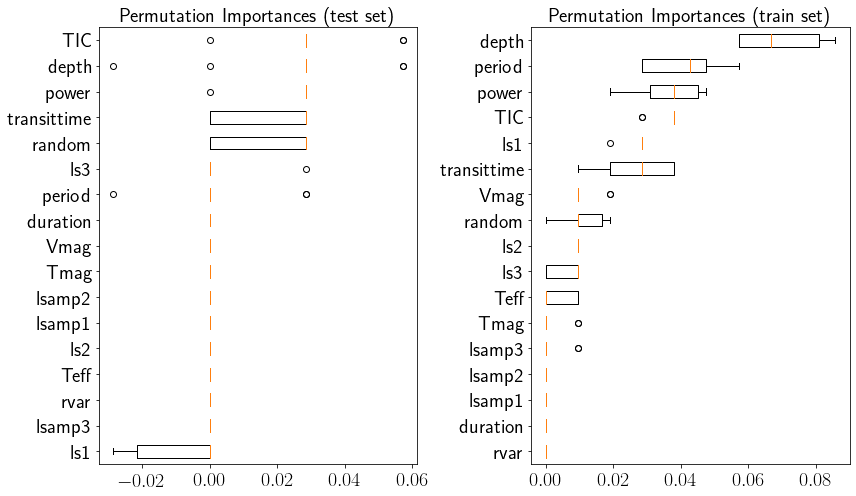

In [30]:
# permutation_importance (one for TRAIN dataset; one for TEST dataset)

result = permutation_importance(rf_model, test_X, test_y, n_repeats=10,
                                random_state=11, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,7))
ax1.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=test_X.columns[sorted_idx])
ax1.set_title("Permutation Importances (test set)",fontsize=20)


result2 = permutation_importance(rf_model, X_train, y_train, n_repeats=10,
                                random_state=11, n_jobs=2)
sorted_idx2 = result2.importances_mean.argsort()
ax2.boxplot(result2.importances[sorted_idx2].T,
           vert=False, labels=X_train.columns[sorted_idx2])
ax2.set_title("Permutation Importances (train set)",fontsize=20)

fig.tight_layout()
plt.show()

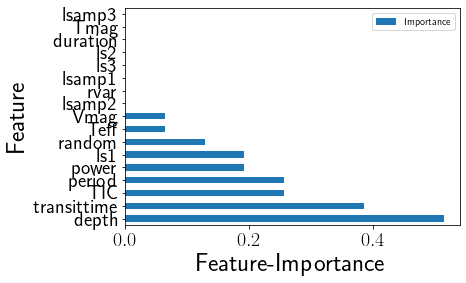

In [31]:
# permutation importance -- a googled way - not sklearn
def r22(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

perm_imp_rfpimp2 = permutation_importances(rf_model, X_train, y_train, r22)

perm_imp_rfpimp2.plot.barh()
plt.xlabel('Feature-Importance');

Feature ranking:
1. feature 11 (0.147355)
2. feature 9 (0.113116)
3. feature 10 (0.109217)
4. feature 0 (0.102963)
5. feature 3 (0.093662)
6. feature 12 (0.077779)
7. feature 1 (0.052458)
8. feature 5 (0.043201)
9. feature 6 (0.040770)
10. feature 4 (0.040423)
11. feature 8 (0.035389)
12. feature 16 (0.035251)
13. feature 14 (0.034359)
14. feature 15 (0.030668)
15. feature 7 (0.022087)
16. feature 2 (0.021304)
17. feature 13 (0.000000)


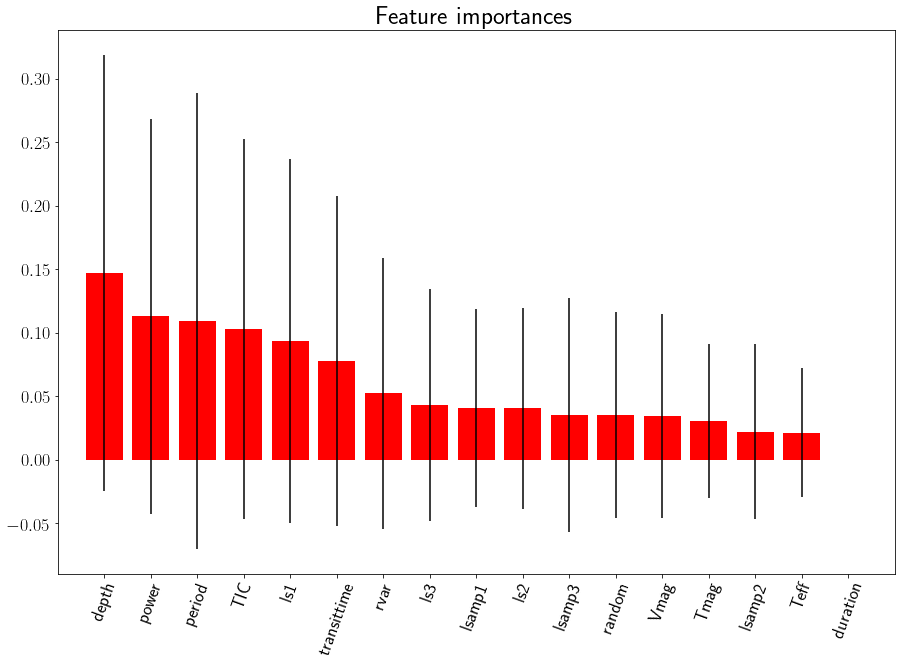

In [32]:
# sklearn - impurity based feature importance (uses training set)

importances2 = rf_model.feature_importances_
std2 = np.std([tree.feature_importances_ for tree in rf_model.estimators_],
             axis=0)
indices2 = np.argsort(importances2)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices2[f], importances2[indices2[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15,10))
plt.title("Feature importances",fontsize=25)
plt.bar(range(X.shape[1]), importances2[indices2],
       color="r", yerr=std2[indices2], align="center")
degrees = 70
plt.xticks(range(X.shape[1]), X.columns[indices2],fontsize=18,rotation=degrees)
plt.xlim([-1, X.shape[1]])
plt.yticks(fontsize=18)
plt.show()

No handles with labels found to put in legend.


depth          0.147355
power          0.113116
period         0.109217
TIC            0.102963
ls1            0.093662
transittime    0.077779
rvar           0.052458
ls3            0.043201
lsamp1         0.040770
ls2            0.040423
lsamp3         0.035389
random         0.035251
Vmag           0.034359
Tmag           0.030668
lsamp2         0.022087
Teff           0.021304
duration       0.000000
dtype: float64


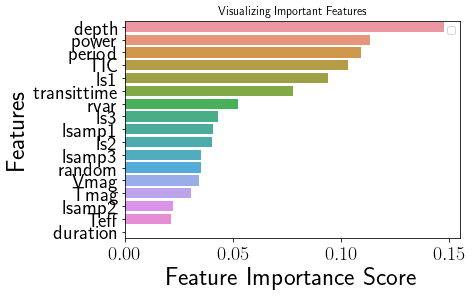

In [48]:
#stsci ds (DSMO) way
feature_imp = pd.Series(rf_model.feature_importances_,index=list(X.columns)).sort_values(ascending=False)
print(feature_imp)
#create a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## Make Predictions -----------------------------------
### _first format the unseen data for model_

In [40]:
## prep unseen data for model evaluation

#change colnames to match features in model
unseen_modelprep = unseen_nogiants.rename(columns={'ls-2':'ls2','ls-3':'ls3',
                                                   'lsamp-1':'lsamp1','lsamp-2':'lsamp2',
                                                   'lsamp-3':'lsamp3','period_bls':'period',
                                                   'power_bls':'power','depth_bls':'depth',
                                                   'dur_bls':'duration',
                                                   'tt_bls':'transittime'})
#inject random number
np.random.seed(seed = 11)
unseen_modelprep['random'] = np.random.random(size = len(unseen_modelprep))
#select only columns used as features
unseen_features = unseen_modelprep[list(final_features.columns)]
#drop nans
unseen_forRF = unseen_features.dropna()

#make predictions
predictions = rf_model.predict(unseen_forRF)
#add predicted class to df
unseen_forRF['predict_class'] = predictions

unseen_forRF



,TIC,rvar,Teff,ls1,ls2,ls3,lsamp1,lsamp2,lsamp3,power,period,depth,transittime,duration,Vmag,Tmag,random,predict_class
0,100008376,41.565918,4260.00,5.966919,14.832070,8.408888,0.052525,0.041702,0.040984,3,0.300162,0.000190,0.166,0.29,12.05400,10.9452,0.180270,1
1,100010286,343.870508,4066.00,6.490677,10.919687,4.590450,0.611177,0.411933,0.153213,55,0.302985,0.000065,0.160,0.29,9.98000,8.5903,0.019475,1
2,100011130,110.547852,6178.00,6.327233,9.736584,18.670184,0.050489,0.042151,0.008676,153,0.308377,0.000050,0.171,0.29,9.02300,8.5310,0.463219,1
3,100011208,44.024072,5786.00,6.614793,4.799858,14.075604,0.016676,0.009957,0.006409,48,0.302603,0.000161,0.151,0.29,11.10400,10.6233,0.724934,1
4,100011351,2164.406250,6163.81,3.376855,13.866910,6.327233,0.035589,0.030294,0.020189,16,0.300865,0.000033,0.160,0.29,5.46456,5.2094,0.420204,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11336,99936804,51.038281,4924.00,1.991261,6.392907,1.060350,0.012843,0.009555,0.008614,9,0.300486,0.000150,0.165,0.29,11.00700,10.3539,0.319481,1
11337,99956360,227.912500,6013.02,9.945577,5.971858,4.634256,0.215262,0.170118,0.047122,4,0.300216,0.000038,0.154,0.29,8.07000,7.5454,0.238499,1
11338,99988199,46.279150,4865.00,11.897165,7.601423,4.717806,0.095436,0.033020,0.032174,28,0.301516,0.000199,0.161,0.29,11.85800,10.7848,0.100988,1
11339,99989665,24.063239,3149.00,3.320681,4.045188,6.437726,0.165936,0.020755,0.016282,25,0.301353,0.000970,0.146,0.29,16.55300,13.5160,0.703921,1


In [43]:
#subselect classes
unseen_periodic = unseen_forRF[unseen_forRF['predict_class']==1] #modulations
unseen_ebs = unseen_forRF[unseen_forRF['predict_class']==3] #ebs
print('{} out of {} predicted PERIODIC'.format(len(unseen_periodic),len(unseen_forRF)))
print('{} out of {} predicted TRANSITING'.format(len(unseen_ebs),len(unseen_forRF)))

9646 out of 11341 predicted PERIODIC
1695 out of 11341 predicted TRANSITING


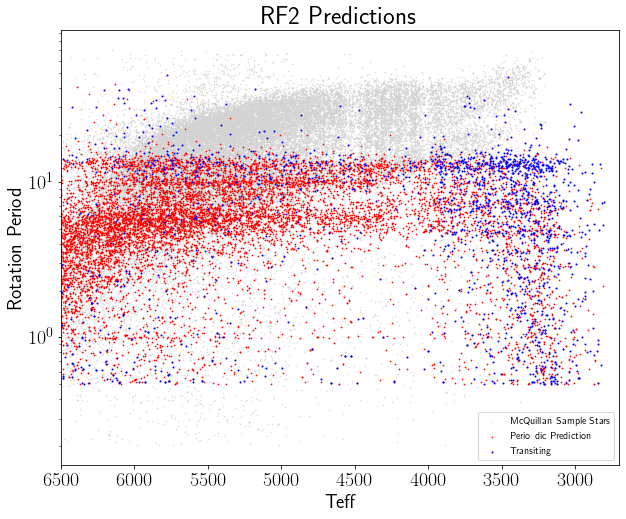

In [51]:
#plot all predictions over MQ data to see results

plt.figure(figsize=(10,8))
plt.scatter(mqdata['TEMP'].to_numpy(),mqdata['ROTATION_PERIOD'].to_numpy(),s=.2,color='lightgrey',label ='McQuillan Sample Stars')
plt.scatter(unseen_periodic['Teff'].to_numpy(),unseen_periodic['ls1'].to_numpy(),s=.5,color='r',label='Perio dic Prediction')
plt.scatter(unseen_ebs['Teff'].to_numpy(),unseen_ebs['ls1'].to_numpy(),s=1,color='b',label='Transiting')
plt.xlim(6500,2700);plt.yscale('log');plt.legend();plt.title('RF2 Predictions',fontsize=25);
plt.ylabel('Rotation Period',fontsize=20);plt.xlabel('Teff',fontsize=20);

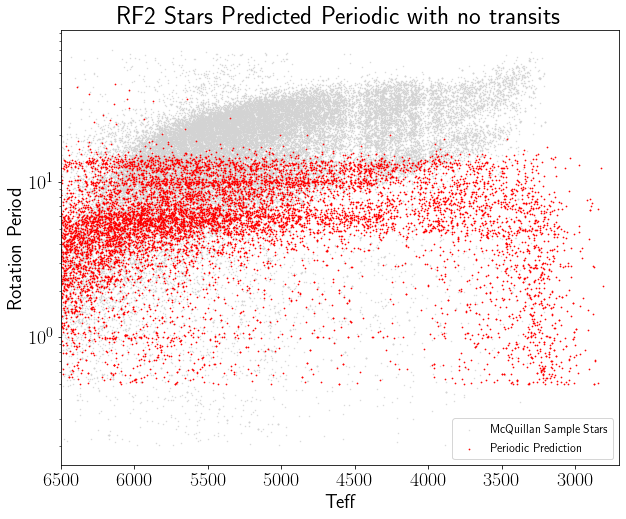

In [55]:
#plot the good predictions over MQ data to see results

plt.figure(figsize=(10,8))
plt.scatter(mqdata['TEMP'].to_numpy(),mqdata['ROTATION_PERIOD'].to_numpy(),s=.2,color='lightgrey',label ='McQuillan Sample Stars')
plt.scatter(unseen_periodic['Teff'].to_numpy(),unseen_periodic['ls1'].to_numpy(),s=.5,color='r',label='Periodic Prediction')
plt.xlim(6500,2700);plt.yscale('log');plt.legend(fontsize='large');plt.title('RF2 Stars Predicted Periodic with no transits',fontsize=25);
plt.ylabel('Rotation Period',fontsize=20);plt.xlabel('Teff',fontsize=20);

In [56]:
#save data to carry over to RF3

#save good predictions----already ran
# unseen_periodic.to_csv('data/RF2_results.csv',index=False)



In [57]:
unseen_periodic

,TIC,rvar,Teff,ls1,ls2,ls3,lsamp1,lsamp2,lsamp3,power,period,depth,transittime,duration,Vmag,Tmag,random,predict_class
0,100008376,41.565918,4260.00,5.966919,14.832070,8.408888,0.052525,0.041702,0.040984,3,0.300162,0.000190,0.166,0.29,12.05400,10.9452,0.180270,1
1,100010286,343.870508,4066.00,6.490677,10.919687,4.590450,0.611177,0.411933,0.153213,55,0.302985,0.000065,0.160,0.29,9.98000,8.5903,0.019475,1
2,100011130,110.547852,6178.00,6.327233,9.736584,18.670184,0.050489,0.042151,0.008676,153,0.308377,0.000050,0.171,0.29,9.02300,8.5310,0.463219,1
3,100011208,44.024072,5786.00,6.614793,4.799858,14.075604,0.016676,0.009957,0.006409,48,0.302603,0.000161,0.151,0.29,11.10400,10.6233,0.724934,1
4,100011351,2164.406250,6163.81,3.376855,13.866910,6.327233,0.035589,0.030294,0.020189,16,0.300865,0.000033,0.160,0.29,5.46456,5.2094,0.420204,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11336,99936804,51.038281,4924.00,1.991261,6.392907,1.060350,0.012843,0.009555,0.008614,9,0.300486,0.000150,0.165,0.29,11.00700,10.3539,0.319481,1
11337,99956360,227.912500,6013.02,9.945577,5.971858,4.634256,0.215262,0.170118,0.047122,4,0.300216,0.000038,0.154,0.29,8.07000,7.5454,0.238499,1
11338,99988199,46.279150,4865.00,11.897165,7.601423,4.717806,0.095436,0.033020,0.032174,28,0.301516,0.000199,0.161,0.29,11.85800,10.7848,0.100988,1
11339,99989665,24.063239,3149.00,3.320681,4.045188,6.437726,0.165936,0.020755,0.016282,25,0.301353,0.000970,0.146,0.29,16.55300,13.5160,0.703921,1
